In [2]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from temgym_core.components import Detector
from temgym_core.utils import wavelength2energy
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import (
    FreeSpaceParaxial, 
    SigmoidAperture,
    run_to_end,
)
from temgym_core.evaluate import (
    eval_gaussians_gpu_kernel_wrapper,
)
from temgym_core.utils import fibonacci_spiral

jax.config.update("jax_enable_x64", True)

In [3]:
W = 20.0  # Width of the simulation cell in nm

Nx = Ny = 128
dx = W/Nx
dy = W/Ny
grid = Detector(z=0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]
extent = (x[0], x[-1], y[0], y[-1])

wavelength = 0.025  # Wavelength in nm (200 keV electrons)
aperture = SigmoidAperture(radius=W/4, sharpness=1000, z=0.0)
free_space = FreeSpaceParaxial(distance=200.0, z=aperture.z)
components = [aperture, free_space]

In [4]:
angstroms_to_metres = 1e-10
voltage = wavelength2energy(wavelength * angstroms_to_metres) # wavelength in meters as this function expects SI units
k0 = 2 * jnp.pi / wavelength
num_rays = 2**16

key1, key2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
num_rays_sqrt = int(jnp.ceil(jnp.sqrt(num_rays)))

rx, ry = fibonacci_spiral(num_rays, radius=W/4)

w0 = 0.1 # Beam waist
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))

aperture_area = np.pi * (W / 4)**2
scale_factor = aperture_area / (w0 ** 2 * num_rays * np.pi)
C0 = jnp.ones(num_rays) * (1.0 * scale_factor + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)

voltage = jnp.full((num_rays,), voltage)

ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=jnp.zeros(num_rays), 
                         dy=jnp.zeros(num_rays), 
                         z=jnp.zeros(num_rays), 
                         pathlength=jnp.zeros(num_rays),
                         Q_inv=Q_inv, 
                         eta=eta, 
                         C=C0,
                         voltage=voltage)

ray_in=ray_in.to_vector()
ray_out = run_to_end(ray_in, [aperture])

In [5]:
E_in = eval_gaussians_gpu_kernel_wrapper(ray_out, grid)

In [6]:
ray_out = run_to_end(ray_in, components)
E_prop = eval_gaussians_gpu_kernel_wrapper(ray_out, grid)

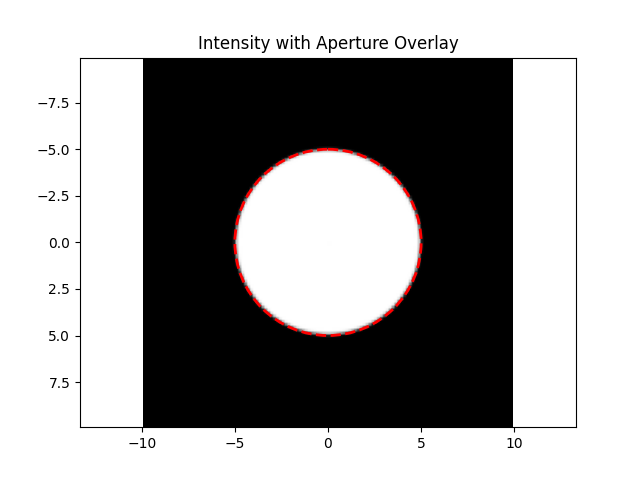

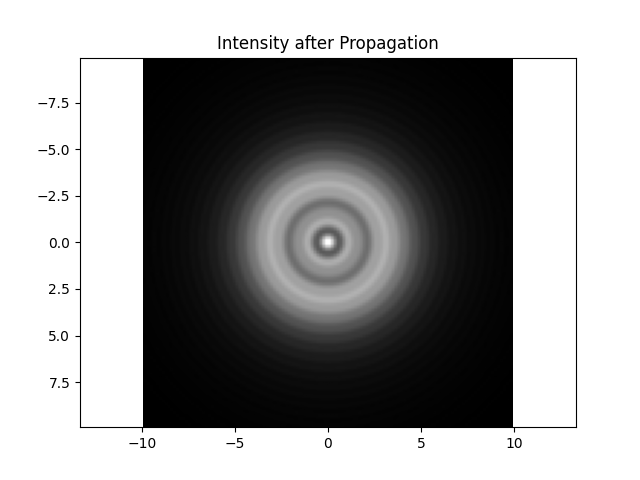

In [7]:
plt.figure()
plt.title('Intensity with Aperture Overlay')
plt.axis('equal')
circle = plt.Circle((0, 0), aperture.radius, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_artist(circle)
plt.imshow(np.abs(E_in), cmap='gray', extent=extent)

plt.figure()
plt.title('Intensity after Propagation')    
plt.axis('equal')
plt.imshow(np.abs(E_prop), cmap='gray', extent=extent)
